# Energy A.I. Hackathon 2023 - Project Template 

## General Guidance

We're expecting a workflow that could be deployed to any competent engineer or scientist with basic subsurface resource, data analytics and machine learning knowledge and they could understand and apply your workflow. 

### Expectations on the Workflow

* include short descriptions, no 2 code blocks should be adjacent, always have a short statement to explain the next code block

* be as concise as possible:

    * use point form (except for the executive summary) 
    * use effective, creative figures that compine what could have been in multiple plots
    * every line of code, statment or figure must have purpose
    * conciseness is part of the grading, don't add content that isn't needed
    
* be very clear with readable code

    * label every axis for every plot
    * use readable code, logical variable names, use available functionality and define functions and classes for compactness and concise comments in the code
    * proceed step by step, explain each important step concisely for a easy to follow narrative 
    
  
### Using Code From Others
  
You may use blocks/snipets of code from other sources with citation. To cite a set of code separate in a block and do this in the markdown above the block.

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_PCA.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb).

```python
def simple_simple_krige(df,xcol,ycol,vcol,dfl,xlcol,ylcol,vario,skmean):
# load the variogram
    nst = vario['nst']; pmx = 9999.9
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
```

or use inline citations with comments, such as this for a few of lines of code.

```python
def simple_simple_krige(df,xcol,ycol,vcol,dfl,xlcol,ylcol,vario,skmean): # function from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb 
```

## The Workflow Template

Here's the template for your workflow.

___

# Energy A.I. Hackathon 2023 Workflow - [Your Team Name] 

#### Authors: [Your Names],  [Your Departments and Schools] 

#### The University of Texas at Austin, Austin, Texas USA 
___

### Executive Summary 

Only 4 short sentences.

1. What is the problem?
2. What did your team do to address the problem?
3. What did your team learn?
4. What does your team recommend going forward?

___

### Workflow Goal

1-2 sentences 
___

### Workflow Steps 

Enumerated steps, very short and concise overview of your methods and workflow

1. **Data Analysis** - basic data checking and visualization
2. **Feature Selection** - mutual information-based approach with minimum redundancy, maximum relevance score
3. **Machine Learning Model \#1** - Predict feature $X$ from $Y,Z$

$\ldots$


### Import Packages

In [1]:
import numpy as np                                      # model arrays
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # building plots
import os                                               # accessing the operating system


import geostatspy.GSLIB as GSLIB                        # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                  # GSLIB methods convert to Python  

In [2]:
import numpy as np                                      # ndarrys for gridded data
import pandas as pd                                     # DataFrames for tabular data
import os                                               # set working directory, run executables
import matplotlib.pyplot as plt                         # for plotting
from matplotlib.colors import ListedColormap            # custom color maps
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from scipy import stats                                 # summary statistics
import math                                             # trigonometry etc.
import scipy.signal as signal                           # kernel for moving window calculation
import random                                           # for randon numbers
import seaborn as sns                                   # for matrix scatter plots
from scipy import linalg                                # for linear regression
from sklearn import preprocessing                       # remove encoding error
from sklearn.feature_selection import RFE               # for recursive feature selection
from sklearn.feature_selection import mutual_info_regression # mutual information
from sklearn.linear_model import LinearRegression       # linear regression model
from sklearn.ensemble import RandomForestRegressor      # model-based feature importance
from statsmodels.stats.outliers_influence import variance_inflation_factor # variance inflation factor
plt.rc('axes', axisbelow=True)                          # girds and axes behind all plot elements
cmap = plt.cm.inferno                                   # default colormap

In [3]:
def partial_corr(C):                                    # partial correlation by Fabian Pedregosa-Izquierdo, f@bianp.net
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C):                                # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] 
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):                         # calculate mutual information matrix
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual

def mutual_information_objective(x,y):                  # modified from MRMR loss function, Ixy - average(Ixx)
    mutual_information_quotient = []
    for i, icol in enumerate(x.columns):
        Vx = mutual_info_regression(x.iloc[:,i].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1)))
        Ixx_mat = []
        for m, mcol in enumerate(x.columns):
            if i != m:
                Ixx_mat.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,i].values.reshape(-1, 1))))
        Wx = np.average(Ixx_mat)
        mutual_information_quotient.append(Vx/Wx)
    mutual_information_quotient  = np.asarray(mutual_information_quotient).reshape(-1)
    return mutual_information_quotient

def delta_mutual_information_quotient(x,y):             # standard mutual information quotient
    delta_mutual_information_quotient = []               
    
    Ixy = []
    for m, mcol in enumerate(x.columns):
        Ixy.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
    Vs = np.average(Ixy)
    Ixx = []
    for m, mcol in enumerate(x.columns):
        for n, ncol in enumerate(x.columns):
            Ixx.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
    Ws = np.average(Ixx) 
    
    for i, icol in enumerate(x.columns):          
        Ixy_s = []                                          
        for m, mcol in enumerate(x.columns):
            if m != i:
                Ixy_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
        Vs_s = np.average(Ixy_s)
        Ixx_s = []
        for m, mcol in enumerate(x.columns):
            if m != i:
                for n, ncol in enumerate(x.columns):
                    if n != i:
                        Ixx_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))                  
        Ws_s = np.average(Ixx_s)
        delta_mutual_information_quotient.append((Vs/Ws)-(Vs_s/Ws_s))
    
    delta_mutual_information_quotient  = np.asarray(delta_mutual_information_quotient).reshape(-1)  
    return delta_mutual_information_quotient

def weighted_avg_and_std(values, weights):              # calculate weighted statistics (Eric O Lebigot, stack overflow)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc):           # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):             # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')
    
    


### Load Data

The following workflow applies the .csv file '300well_MV.csv', a synthetic dataset calculated with geostatistical cosimulation by Wayne Gretzky, The Edmonton Oilers Hockey Team. The dataset is publically available [here](http://www.hasthelargehadroncolliderdestroyedtheworldyet.com/)  

We will work with the following features:

* **porosity** - fraction of rock void in units of percentage
* **permeability** - ability of a fluid to flow through the rock in mil;iDarcy
* **acoustic impedence** - product of sonic velocity and rock density in unitsof $kg/m^2s*10^3$

In [248]:
# os.chdir("c:/PGE383")                                   # set the working directory

my_data = pd.read_csv("dailyData.csv")                  # load the comma delimited data file
#my_data = my_data.iloc[:,1:]                           # copy all rows and columns 1 through 8, note 0 column is removed

In [247]:
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

my_data.tail()

#How to tackle wells with long missing data





,OIL,GAS,WATER,ARTIFICIAL_LIFT,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,AL_Key,Well_ID
50051,130.568357,335.639084,433.161488,ESP,0.0,232.000000,433.000000,894.599976,240.0,182.800003,55.000000,0.550000,20.000000,167.384209,444.562318,856.745525,611.946527,0.583339,0.537389,460.405623,396.339903,150.908634,184.730450,3004.191331,2598.063044,757.792307,0.059549,1703.463069,1746.331510,0.168102,18.724074,100.456000,0.207101,81.731926,168.679595,600.0,ESP_1,142
50052,135.061535,338.161005,421.979434,ESP,0.0,232.000000,433.000000,894.599976,240.0,182.800003,55.000000,0.550000,20.000000,173.144311,433.085059,858.684065,606.229370,0.586167,0.534518,458.981681,399.702384,150.441904,187.719102,3004.191331,2563.037417,754.692653,0.061011,1668.437442,1728.818696,0.171957,18.264067,100.456000,0.202013,82.191933,168.766911,600.0,ESP_1,142
50053,135.757477,341.732930,428.363835,ESP,0.0,230.433113,431.364779,893.432975,240.0,182.836947,55.000000,0.551651,20.133889,174.012642,439.638975,870.139131,613.651616,0.586430,0.533871,464.542110,405.597021,152.038065,189.694864,3004.191331,2556.744207,764.843078,0.062554,1663.311231,1725.088591,0.173214,18.452844,99.400729,0.206268,80.947885,168.672755,600.0,ESP_1,142
50054,64.788755,170.379740,221.002588,ESP,12.0,243.458937,423.202102,934.540501,240.0,186.748578,54.836954,0.549735,21.480732,83.449011,226.808990,413.161203,310.258001,0.571123,0.562801,232.527414,180.633789,80.110123,90.269617,3004.191331,2538.622702,380.889908,0.060600,1604.082202,1736.581602,0.162718,8.862240,103.032334,0.095571,94.170094,172.715382,600.0,ESP_1,142
50055,0.000000,0.000000,0.000000,ESP,24.0,369.099649,402.275272,1527.854901,240.0,224.843614,55.352147,0.329761,27.697993,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,763.927450,NaN,NaN,148.479662,NaN,NaN,NaN,600.0,ESP_1,142


In [6]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50056 entries, 0 to 50055
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   OIL                                             50052 non-null  float64
 1   GAS                                             50052 non-null  float64
 2   WATER                                           50052 non-null  float64
 3   ARTIFICIAL_LIFT                                 50052 non-null  object 
 4   DOWN_TIME_HOURS                                 50052 non-null  float64
 5   ESP Data - Drive Current                        40177 non-null  float64
 6   ESP Data - Drive Voltage                        41449 non-null  float64
 7   ESP Data - Intake Pressure                      39824 non-null  float64
 8   ESP Data - Motor Temperature Shutdown Setpoint  32397 non-null  float64
 9   ESP Data - Motor Winding Temperature   

In [7]:
my_data.describe()

,OIL,GAS,WATER,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,Well_ID
count,50052.000000,50052.000000,50052.000000,50052.000000,40177.000000,41449.000000,39824.000000,32397.000000,40078.000000,42369.000000,31332.000000,44351.000000,40121.000000,40125.000000,40099.000000,40125.000000,39950.000000,39950.000000,39949.000000,39950.000000,39950.000000,39950.000000,39825.000000,35540.000000,39949.000000,3.763200e+04,34724.000000,37016.000000,3.838700e+04,34722.000000,39832.000000,32078.000000,37183.000000,32954.000000,33869.000000,50056.000000
mean,586.684746,683.051091,803.821808,0.993900,256.673039,416.194779,1090.615958,460.818960,180.897056,56.586441,26.506865,61.292835,817.486359,848.394287,1187.558230,1666.387919,0.434924,0.550327,573.006969,620.794733,190.595178,510.571279,2157.887755,2773.811035,2064.270715,1.774602e-01,1698.024421,1890.881581,1.740643e-01,38.749969,108.073650,0.378877,80.128262,164.493709,1056.314033,137.772395
std,416.097647,357.946248,649.389332,3.962034,68.674683,50.572335,559.504784,724.402577,9.210206,5.244889,119.750461,319.460377,617.038008,665.318994,851.336575,1166.599610,0.251089,0.143359,339.588739,582.602258,122.465317,294.435353,603.285578,624.971879,1192.927162,3.215276e-01,651.538135,572.084984,2.259487e-01,23.685941,28.065324,0.184717,35.746098,6.391313,594.611931,113.120075
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.599873,0.000000,135.223159,5.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,701.675330,1000.017996,0.012324,0.000000e+00,3.998846,500.016481,0.000000e+00,0.065588,30.265603,0.000658,0.837517,145.950205,175.000000,0.000000
25%,294.586269,439.684454,351.194557,0.000000,226.351533,395.794169,768.650186,230.000000,174.604694,54.000000,0.000000,8.000000,396.841077,370.796333,489.540670,819.272073,0.231538,0.453275,316.071972,159.921985,104.373823,301.498440,1689.165486,2386.326396,1157.096688,1.110000e-16,1271.655861,1580.943809,1.110000e-16,21.245901,93.387680,0.243109,57.990861,161.844117,675.000000,50.000000
50%,482.662466,660.094888,604.544784,0.000000,259.103629,423.461516,919.291387,240.000000,180.036207,58.000000,0.017917,19.000000,630.087413,630.471145,1195.756077,1260.915773,0.503336,0.548580,629.639210,526.702012,187.475664,465.757675,2219.329907,2840.032372,1752.014767,2.220000e-16,1760.394227,1858.147862,5.710657e-02,33.807649,108.695271,0.358939,76.414622,165.621877,800.000000,102.000000
75%,785.061899,917.471681,1082.319580,0.000000,295.181748,443.312180,1196.165042,240.000000,186.310482,60.000000,0.400736,37.000000,1060.763678,1162.091885,1778.569858,2249.713278,0.637698,0.633840,831.946463,954.667943,271.642458,676.926805,2687.626434,3210.505444,2808.356901,1.895152e-01,2163.639322,2172.520632,3.033109e-01,51.563475,124.107305,0.499620,95.539242,168.748081,1450.000000,252.000000
max,3979.729266,3460.787784,7011.564091,24.000000,570.267352,487.500000,4519.367705,4460.000000,260.799988,69.000000,1288.456366,3466.000000,5330.747102,7168.816766,10325.627120,9933.143674,1.000000,1.000000,1870.891275,10142.015180,883.577593,3138.533966,3376.916650,5865.744030,10074.893710,1.000000e+00,4791.517048,4881.811307,1.000000e+00,191.143370,233.379053,0.999723,297.162058,199.201965,3550.000000,362.000000


In [153]:
test=my_data[(my_data["Well_ID"]==327) & (my_data["AL_Key"]=="ESP_1")]
test

,OIL,GAS,WATER,ARTIFICIAL_LIFT,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,AL_Key,Well_ID
838,178.181226,145.721524,146.775146,ESP,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,327
839,1270.565335,813.464403,1298.498026,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,327
840,1300.500417,791.719070,1004.280949,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,327
841,1058.261008,855.147115,736.038963,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,327
842,1041.881512,908.088822,609.306049,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,327
843,921.415359,737.927339,638.625245,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,327
844,909.634134,705.095052,577.398099,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,327
845,929.430012,715.910202,575.621703,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,327
846,940.539362,755.166020,568.321680,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,327
847,959.892413,783.271770,601.787159,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,327


In [186]:
d = {}
for i in range (0,362):
    #my_data.loc[my_data["Well_ID"]==i]
    d["wellno{0}".format(i)]=my_data.loc[my_data["Well_ID"]==i]
    
#for i in range (0,362):
    

#df_wells=my_data["Well_ID"]

for i in range (0,362):
    #my_data.loc[my_data["Well_ID"]==i]
    d["wellno{0}".format(i)]=my_data.loc[my_data["Well_ID"]==i]
    

(array([11., 24., 30., 25., 33., 18., 12.,  6.,  0.,  6.]),
 array([  1. ,  80.6, 160.2, 239.8, 319.4, 399. , 478.6, 558.2, 637.8,
        717.4, 797. ]),
 <BarContainer object of 10 artists>)

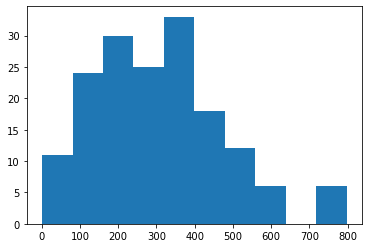

In [249]:
grouped_data=my_data.groupby(["Well_ID","AL_Key"])

grouped_data.head()

life=grouped_data.size()

plt.hist(life)

In [250]:
grouped_data.mean()

OIL          GAS        WATER  DOWN_TIME_HOURS  \
Well_ID AL_Key                                                           
0       ESP_1   1200.239040   998.871480  1072.443059         0.439597   
1       ESP_2    844.774621   858.418777  1186.059028         2.119208   
4       ESP_2    374.479112   494.365467   248.126355         1.003125   
5       ESP_1    380.827029   615.340411   751.458386         0.375740   
6       ESP_1    493.867777   738.811488   763.799862         0.349057   
7       ESP_1   1013.732313   683.703686  1161.401933         0.297189   
        ESP_2    347.387510   443.632931   421.014690         0.816547   
10      ESP_1   1262.711556   690.016541  2014.288540         0.095238   
        ESP_2    392.122551   299.046865   475.629173         4.149780   
11      ESP_1    634.498573   793.270153   531.791402         1.190926   
12      ESP_1    806.624008   793.888347  1296.851831         0.440972   
13      ESP_1    882.759728   559.172893   990.976226         0.441558   
14      ESP_1    639.666835   819.261734   515.844318         1.033264   
15      ESP_1    579.432456   711.842406  1021.756530         3.202542   
        ESP_2    131.135943   522.721632   257.455803         0.624269   
16      ESP_1   1074.457530   677.364023  1117.662757         0.673820   
17      ESP_1    528.238938   543.615572   526.863973         0.818352   
18      ESP_1    137.842390   585.067600   458.631660         1.108948   
19      ESP_1    463.166128   448.368612   443.069191         0.565427   
20      ESP_1   1405.857696   780.235322  1682.796611         1.131579   
21      ESP_1   1357.657191   788.329173  2336.041771         1.142857   
22      ESP_1    733.196449   746.473743   589.482381         0.477427   
23      ESP_1   1074.242340   745.668775   624.493676         0.588670   
25      ESP_1    987.785348   729.622899   697.903401         0.158263   
27      ESP_1   1731.035958  1201.943402  1180.206831         0.461929   
28      ESP_1    456.116706   622.116987  1005.047864         0.326409   
29      ESP_3    501.728542   883.330869   499.590086         0.749386   
30      ESP_2    447.362756   426.812330   770.129330         0.181818   
32      ESP_1   1340.010483  1259.172293  1510.344113         0.691358   
33      ESP_1    722.517404   885.696473  1271.183002         0.266667   
35      ESP_1    566.369075   647.614540   551.584499         0.330224   
37      ESP_1   1053.019457   679.913319   706.437888         0.357955   
40      ESP_1    790.313813   714.043716   904.640658         0.913732   
42      ESP_1    648.065161   823.962581   674.931683         0.254448   
43      ESP_1    693.175286   834.337596   691.817374         0.494208   
44      ESP_1    472.644309   836.945814   969.553874         1.748005   
45      ESP_1    658.372004  1064.409808   712.902099         1.656437   
47      ESP_1    815.663802   544.972157  1463.387455         0.395437   
48      ESP_1    646.561147   807.253531  1090.700035         0.511858   
49      ESP_1    962.607461   792.751485  1243.183331         1.619195   
50      ESP_1    746.657070   514.328900   668.252645         2.460494   
        ESP_2    261.514737   227.786952   161.661934         2.616732   
51      ESP_1    717.595165   834.500361   830.787415         0.336735   
52      ESP_2    681.478107   980.296946   626.265574         1.085714   
53      ESP_2    439.041265   452.373721   455.563299         1.654570   
54      ESP_2    434.866761   377.844528   559.197434         1.662752   
55      ESP_1    724.854756   802.374513  1840.545632         0.675182   
59      ESP_1    688.617961   467.392512   793.175306         0.604706   
60      ESP_1    520.010560   455.022708   798.463655         0.651163   
61      ESP_1   1445.196558  1269.476445  1514.128591         0.533333   
62      ESP_1    693.027300   750.763415   817.620702         0.427966   
63      ESP_2    479.099158   842.751958   527.257061         1.064171   
64      ESP_1    459.622083 

In [261]:
array_life=np.array(grouped_data.size())

In [262]:
array_life.shape

(165,)

In [300]:
mega_matrix=np.array(grouped_data)
trest=mega_matrix[0][1]
trest[2:3]["OIL"]

C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\1232692239.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mega_matrix=np.array(grouped_data)


5078    1787.943272
Name: OIL, dtype: float64

In [312]:
mega_matrix.shape

(165, 2)

In [324]:
mega_f=np.copy(mega_matrix)

In [330]:
mega_f[0][0][0]

0

In [331]:
for i in range (0,len(mega_matrix)):
    for k in range(0,len(solution_array)):
        if mega_f[i][0][0] == solution_array[0] & mega_f[i][0][1] == solution_array[1]:
            mega_f[i].isnull()
    

TypeError: unsupported operand type(s) for &: 'int' and 'str'

In [306]:
for i in range (len(grouped_data)):
    overall_time=array_life[i]
    senior=overall_time-int((overall_time*0.1).round(0))
    mega_matrix[i][1][senior:overall_time]["OIL"]
    

In [309]:
solution_df = pd.read_csv("solution.csv")  # Read in solutions.csv
solution_df.head()



,Well_ID,AL_Key,Fail in 30 days
0,327,ESP_1,0
1,125,ESP_2,1
2,260,ESP_3,0
3,21,ESP_1,1
4,16,ESP_1,0


In [310]:
solution_array=np.array(solution_df) # Get the Well_ID

In [311]:
solution_array[0,0]

327

In [178]:
matrix=np.array([5,362])

In [ ]:
for i in range (0,362):
    d["wellno{0}".format(i)]=my_data.loc[my_data["Well_ID"]==i]

In [175]:
life_eps1=[]
for i in range (0,400):
    test=len(my_data[(my_data["Well_ID"]==i) & (my_data["AL_Key"]=="ESP_1")])
    life_eps1.append([test])
for value in range(0,len(life_eps1)):
    if life_eps1[value] <= 0:
        del life_eps1[value]

plt.hist(life_eps1)


TypeError: '<=' not supported between instances of 'list' and 'int'

In [110]:
life=[]
for i in range (0,400):
    #my_data.loc[my_data["Well_ID"]==i]
    if my_data["AL_Key"][i]=="ESP_1":
        life.append([i,len(my_data.loc[my_data["Well_ID"]==i])])
    #elif y_data["AL_Key"][i]="ESP_2":
    #    life.append(len(my_data.loc[my_data["Well_ID"]==i]))
    
life

[]

In [ ]:
    


plt.plot(d["wellno345"]["GAS"]/d["wellno345"]["OIL"])


#for i in range (0,362):
    

#df_wells=my_data["Well_ID"]




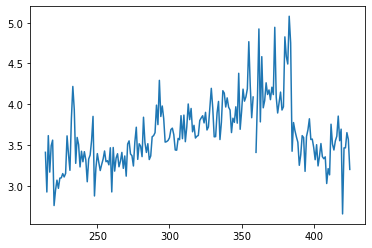

In [9]:
plt.plot(d["wellno345"]["Gas_Intake"]/d["wellno345"]["Oil_Intake"])


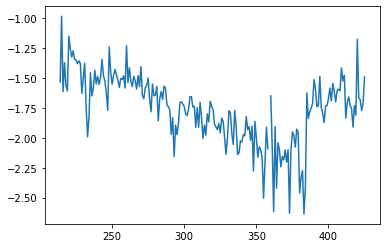

In [10]:
plt.plot(d["wellno345"]["GAS"]/d["wellno345"]["OIL"]-d["wellno345"]["Gas_Intake"]/d["wellno345"]["Oil_Intake"])


In [11]:
d["wellno345"].head()

,OIL,GAS,WATER,ARTIFICIAL_LIFT,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,AL_Key,Well_ID
0,615.154601,650.447788,526.488655,ESP,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
1,1224.193640,1232.455787,809.414685,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
2,1007.769762,1047.068544,667.933899,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
3,1514.641876,1370.143160,1122.137652,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
4,1089.741764,1387.138130,1156.169599,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345


In [12]:
well_no_345=my_data.loc[my_data["Well_ID"]==345]
well_no_345.tail()

,OIL,GAS,WATER,ARTIFICIAL_LIFT,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,AL_Key,Well_ID
426,310.534376,665.662373,387.024129,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
427,263.468895,531.043553,287.802970,ESP,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
428,257.310251,509.170566,336.918101,ESP,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
429,318.877302,605.508428,400.060895,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
430,329.416360,629.020704,431.660834,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345


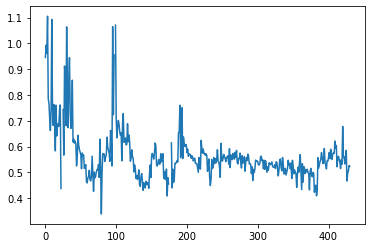

In [13]:
plt.plot(well_no_345["OIL"]/well_no_345["GAS"])

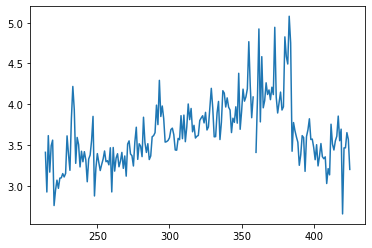

In [14]:
plt.plot(well_no_345["Gas_Intake"]/well_no_345["Oil_Intake"])

In [15]:
well_no_345.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431 entries, 0 to 430
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   OIL                                             431 non-null    float64
 1   GAS                                             431 non-null    float64
 2   WATER                                           431 non-null    float64
 3   ARTIFICIAL_LIFT                                 431 non-null    object 
 4   DOWN_TIME_HOURS                                 431 non-null    float64
 5   ESP Data - Drive Current                        211 non-null    float64
 6   ESP Data - Drive Voltage                        211 non-null    float64
 7   ESP Data - Intake Pressure                      211 non-null    float64
 8   ESP Data - Motor Temperature Shutdown Setpoint  0 non-null      float64
 9   ESP Data - Motor Winding Temperature       

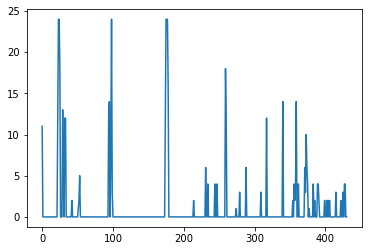

In [16]:
well_no_345["DOWN_TIME_HOURS"].sum()
plt.plot(well_no_345["DOWN_TIME_HOURS"])

In [91]:
static_df = pd.read_csv("wellData.csv")    

static_df

# Count NaN for each feature
# Determine which features to remove strictly on this



,Unnamed: 0,Well_ID,AL_Key,Artificial_Lift_Type,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Frequency_Rating,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth,Failure_Type,Failure_Type_Detail
0,0,345,ESP_2,ESP,9056.67,0,5.323174,NaN,NaN,NaN,NaN,1.713554,ELECTRICAL,MOTOR
1,1,29,ESP_3,ESP,8982.09,0,6.440650,NaN,NaN,NaN,NaN,2.789395,PUMP,MOTOR
2,2,327,ESP_1,ESP,8876.37,0,5.669751,NaN,NaN,NaN,NaN,0.481680,ELECTRICAL,UNKNOWN
3,3,71,ESP_1,ESP,8930.11,0,5.614798,NaN,NaN,NaN,NaN,0.842038,ELECTRICAL,UNKNOWN
4,4,125,ESP_2,ESP,8616.41,348,26.061750,NaN,NaN,NaN,NaN,NaN,ELECTRICAL,PENETRATOR
5,5,165,ESP_1,ESP,8894.94,267,16.324035,NaN,67.1,2626.0,270.0,NaN,TUBING,UNKNOWN
6,6,165,ESP_2,ESP,8814.55,351,23.472619,NaN,67.1,2626.0,270.0,NaN,ELECTRICAL,MOTOR
7,7,138,ESP_1,ESP,8708.70,267,16.903383,NaN,67.1,2626.0,270.0,NaN,TUBING,BODY
8,8,138,ESP_2,ESP,8718.55,287,23.571040,NaN,67.1,2626.0,270.0,NaN,PUMP,STAGE
9,9,260,ESP_1,ESP,8711.08,267,16.869503,NaN,67.1,2626.0,270.0,NaN,TUBING,BODY


In [18]:
static_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  166 non-null    int64  
 1   Well_ID                     166 non-null    int64  
 2   AL_Key                      166 non-null    object 
 3   Artificial_Lift_Type        166 non-null    object 
 4   AL_Bottom_Depth             166 non-null    float64
 5   ESP_Pump_Stages             166 non-null    int64  
 6   DLS_Critical                163 non-null    float64
 7   ESP_Motor_Frequency_Rating  10 non-null     float64
 8   ESP_Motor_Current_Rating    85 non-null     float64
 9   ESP_Motor_Voltage_Rating    85 non-null     float64
 10  ESP_Motor_Power_Rating      85 non-null     float64
 11  DLS_at_Set_Depth            67 non-null     float64
 12  Failure_Type                166 non-null    object 
 13  Failure_Type_Detail         165 non

In [19]:
static_df.describe()

,Unnamed: 0,Well_ID,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Frequency_Rating,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth
count,166.000000,166.000000,166.000000,166.000000,163.000000,10.0,85.000000,85.000000,85.000000,67.000000
mean,82.500000,130.584337,8077.384518,234.885542,17.250072,60.0,70.781176,2230.929412,227.922353,4.844286
std,48.064193,107.306085,785.601429,175.935264,6.332956,0.0,45.378206,838.594669,86.662526,17.647618
min,0.000000,0.000000,0.000000,0.000000,4.879671,60.0,18.000000,1055.000000,18.000000,0.092562
25%,41.250000,50.250000,7784.477500,0.000000,13.133512,60.0,67.100000,1393.000000,161.000000,0.321964
50%,82.500000,99.500000,8131.600000,267.000000,17.561921,60.0,67.100000,2626.000000,216.000000,0.682052
75%,123.750000,165.000000,8544.970000,415.000000,20.490922,60.0,75.000000,2626.000000,270.000000,2.266419
max,165.000000,362.000000,9056.670000,504.000000,36.113674,60.0,456.000000,4181.000000,456.000000,143.251918


In [20]:
solution_df = pd.read_csv('solution.csv')
solution_df.head()

,Well_ID,AL_Key,Fail in 30 days
0,327,ESP_1,0
1,125,ESP_2,1
2,260,ESP_3,0
3,21,ESP_1,1
4,16,ESP_1,0


### Functions

The following functions will be used in the workflow.

In [21]:
def plot_corr(dataframe,size=10):                       # plots a correlation matrix as a heat map 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

### Basic Data Checking and Visualization

Since our method relies on the assumption of pairwise correlation, we check the correlation matrix and confirm this. 

* the absolute pariwise correlations exceed 0.6 for por and logperm, por and AI, AI and TOC etc. 

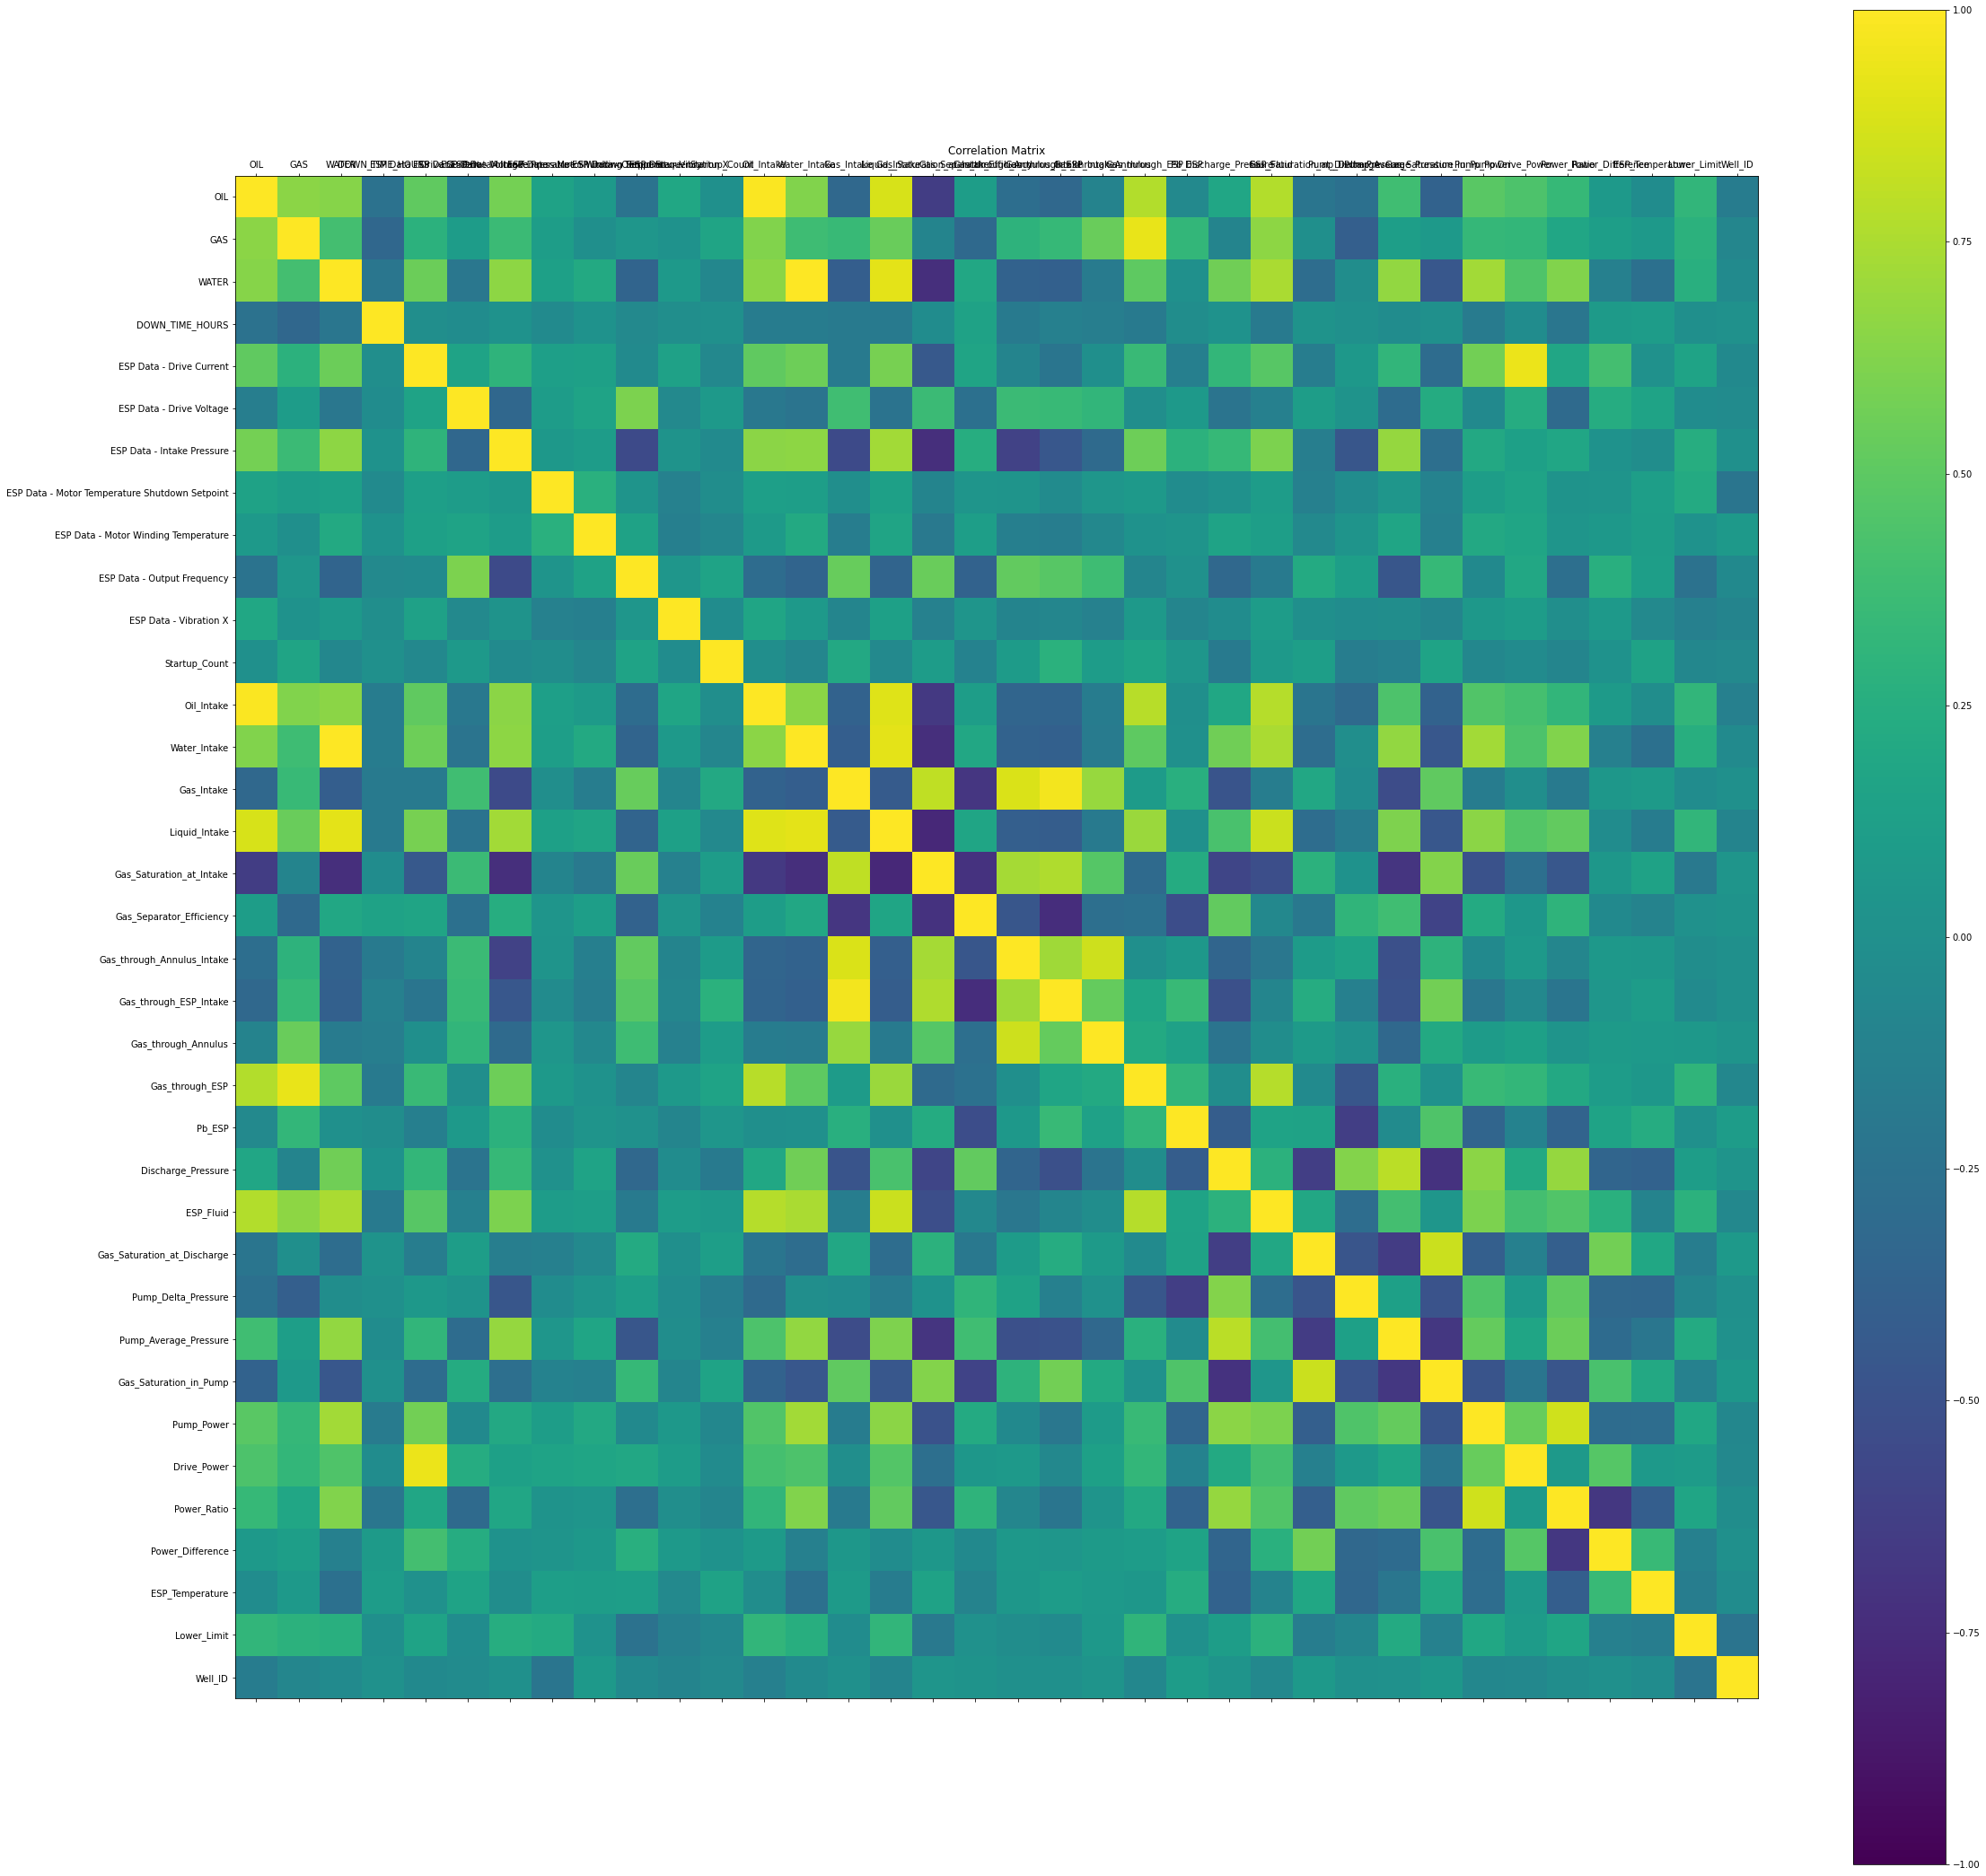

In [22]:
plot_corr(my_data,size = 38)

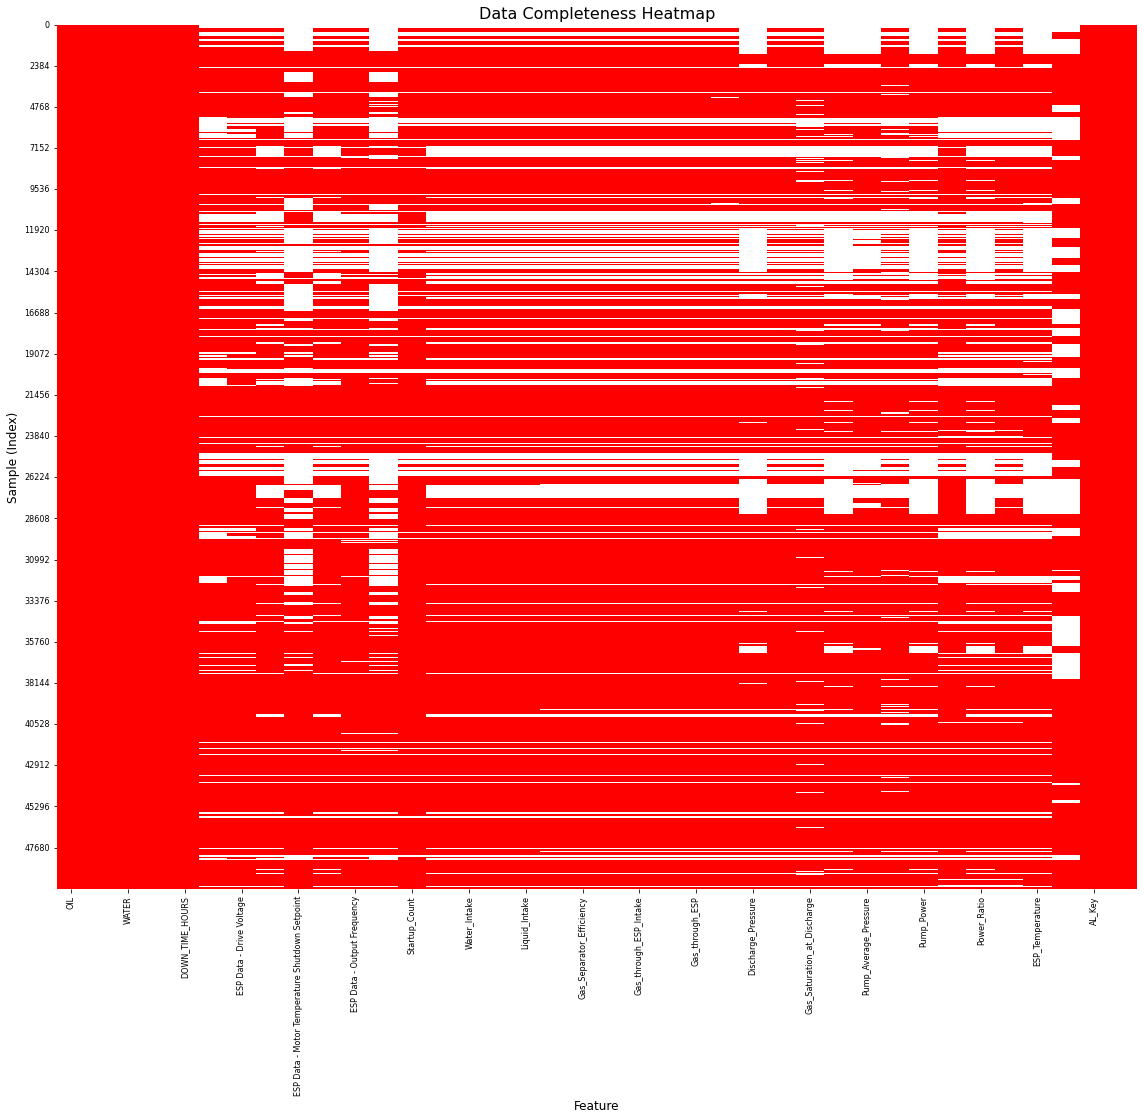

In [23]:
df_temp = my_data.copy(deep=True)                            # make a deep copy of the DataFrame

df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.001) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=3, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

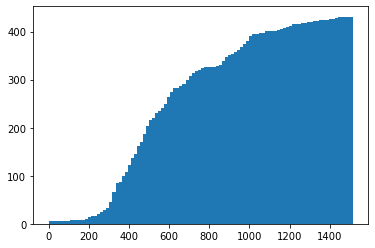

In [24]:
plt.hist(d["wellno345"]["OIL"],cumulative=True, bins=100);

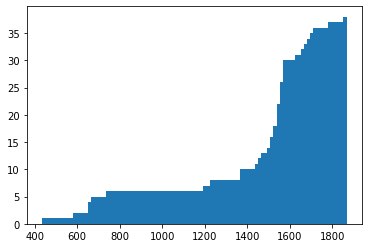

In [25]:
plt.hist(d["wellno20"]["OIL"],cumulative=True, bins=100);

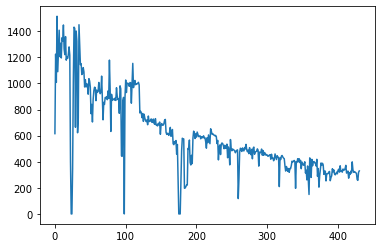

In [26]:
plt.plot(d["wellno345"]["OIL"])

In [27]:
#cleaned2.reset_index(drop=True,inplace=True)

C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\3465063502.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["wellno345"]["cum_oil"]=d["wellno345"]["OIL"].cumsum(axis = 0);


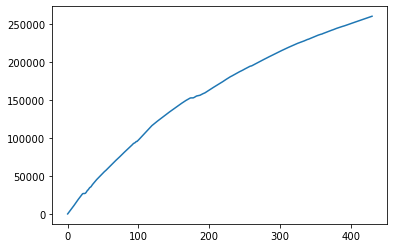

In [28]:
c=0
d["wellno345"]["cum_oil"]=d["wellno345"]["OIL"].cumsum(axis = 0);

plt.plot(d["wellno345"]["cum_oil"])



C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\2569691711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["wellno327"]["cum_oil"]=d["wellno327"]["OIL"].cumsum(axis = 0);


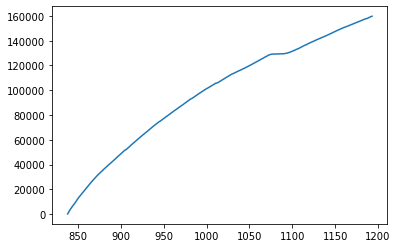

In [59]:
c=0
d["wellno327"]["cum_oil"]=d["wellno327"]["OIL"].cumsum(axis = 0);

plt.plot(d["wellno327"]["cum_oil"])


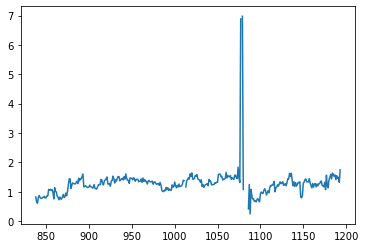

In [62]:
plt.plot(d["wellno327"]["GAS"]/d["wellno327"]["OIL"])

C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\2672708789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["wellno345"]["delta_qo"]=d["wellno345"]["OIL"].diff();


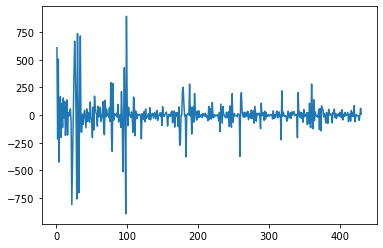

In [48]:
d["wellno345"]["delta_qo"]=d["wellno345"]["OIL"].diff();
plt.plot(d["wellno345"]["delta_qo"])

C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\2957432711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["wellno345"]["delta2_qo"]=d["wellno345"]["delta_qo"].diff();


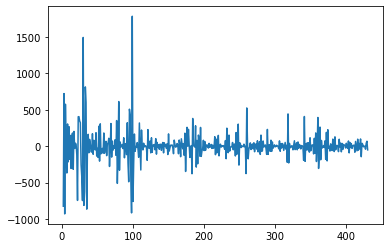

In [50]:
d["wellno345"]["delta2_qo"]=d["wellno345"]["delta_qo"].diff();
plt.plot(d["wellno345"]["delta2_qo"])

C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\4267339754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["wellno21"]["delta_qo"]=d["wellno21"]["OIL"].diff();


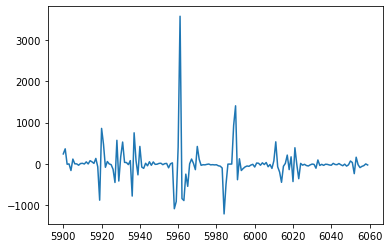

In [52]:
d["wellno21"]["delta_qo"]=d["wellno21"]["OIL"].diff();
plt.plot(d["wellno21"]["delta_qo"])

C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\3963594797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["wellno21"]["delta2_qo"]=d["wellno21"]["delta_qo"].diff();


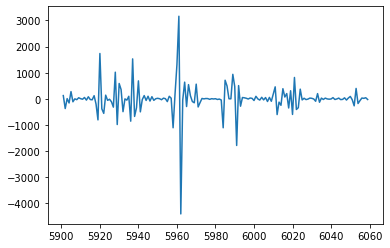

In [55]:
d["wellno21"]["delta2_qo"]=d["wellno21"]["delta_qo"].diff();
plt.plot(d["wellno21"]["delta2_qo"])

C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\3999190093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["wellno327"]["delta_qo"]=d["wellno327"]["OIL"].diff();


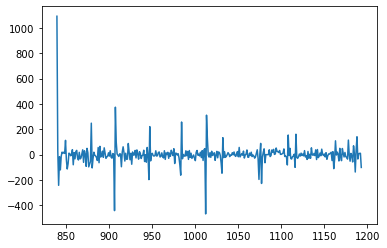

In [53]:
d["wellno327"]["delta_qo"]=d["wellno327"]["OIL"].diff();
plt.plot(d["wellno327"]["delta_qo"])

C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\2066469832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["wellno327"]["delta2_qo"]=d["wellno327"]["delta_qo"].diff();


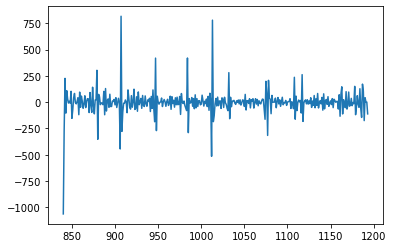

In [56]:
d["wellno327"]["delta2_qo"]=d["wellno327"]["delta_qo"].diff();
plt.plot(d["wellno327"]["delta2_qo"])

C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\4144754395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["wellno260"]["delta_qo"]=d["wellno260"]["OIL"].diff();


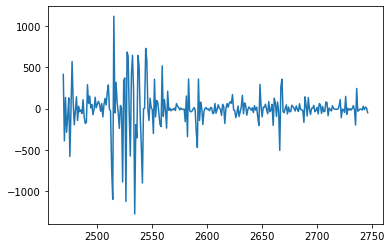

In [54]:
d["wellno260"]["delta_qo"]=d["wellno260"]["OIL"].diff();
plt.plot(d["wellno260"]["delta_qo"])

In [30]:
# Combine both well and daily data according to the specific well and pump
combined_data = pd.merge(static_df, my_data, on=["Well_ID", "AL_Key"])

In [31]:
# All wells in solution
solution_df = pd.read_csv("solution.csv")  # Read in solutions.csv
solution_ids = solution_df["Well_ID"].to_numpy()         # Get the Well_ID

In [32]:
# Creates a dataframe with only the data for the wells that haven't failed
solution_data = combined_data[combined_data["Well_ID"].isin(solution_ids)]

In [38]:
solution_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12406 entries, 838 to 49229
Data columns (total 50 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Unnamed: 0                                      12406 non-null  int64  
 1   Well_ID                                         12406 non-null  int64  
 2   AL_Key                                          12406 non-null  object 
 3   Artificial_Lift_Type                            12406 non-null  object 
 4   AL_Bottom_Depth                                 12406 non-null  float64
 5   ESP_Pump_Stages                                 12406 non-null  int64  
 6   DLS_Critical                                    12406 non-null  float64
 7   ESP_Motor_Frequency_Rating                      139 non-null    float64
 8   ESP_Motor_Current_Rating                        6378 non-null   float64
 9   ESP_Motor_Voltage_Rating             

In [44]:
solution_data.head()

,Unnamed: 0,Well_ID,AL_Key,Artificial_Lift_Type,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Frequency_Rating,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth,Failure_Type,Failure_Type_Detail,OIL,GAS,WATER,ARTIFICIAL_LIFT,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit
838,2,327,ESP_1,ESP,8876.37,0,5.669751,NaN,NaN,NaN,NaN,0.48168,ELECTRICAL,UNKNOWN,178.181226,145.721524,146.775146,ESP,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
839,2,327,ESP_1,ESP,8876.37,0,5.669751,NaN,NaN,NaN,NaN,0.48168,ELECTRICAL,UNKNOWN,1270.565335,813.464403,1298.498026,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
840,2,327,ESP_1,ESP,8876.37,0,5.669751,NaN,NaN,NaN,NaN,0.48168,ELECTRICAL,UNKNOWN,1300.500417,791.719070,1004.280949,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
841,2,327,ESP_1,ESP,8876.37,0,5.669751,NaN,NaN,NaN,NaN,0.48168,ELECTRICAL,UNKNOWN,1058.261008,855.147115,736.038963,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
842,2,327,ESP_1,ESP,8876.37,0,5.669751,NaN,NaN,NaN,NaN,0.48168,ELECTRICAL,UNKNOWN,1041.881512,908.088822,609.306049,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


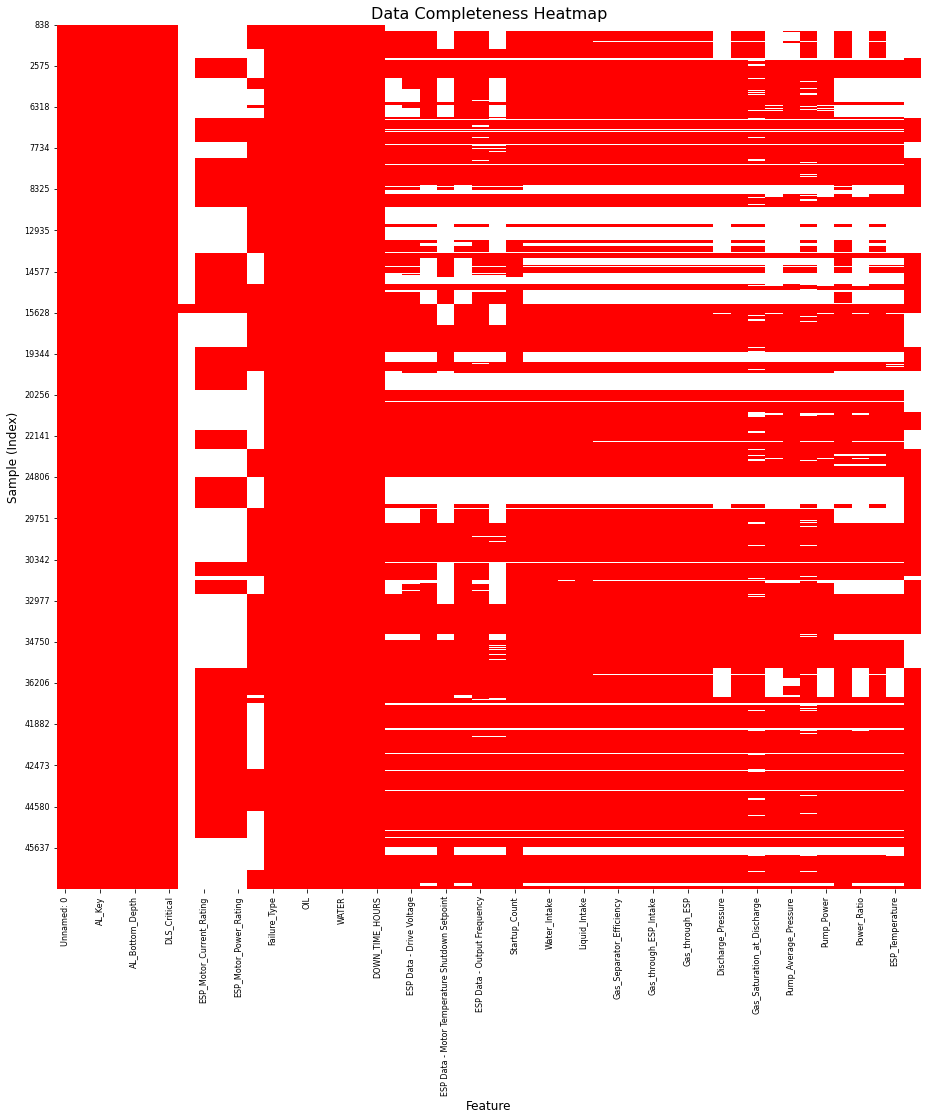

In [42]:
df_temp = solution_data.copy(deep=True)                            # make a deep copy of the DataFrame

df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.001) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)

 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=3, wspace=0.2, hspace=0.5) # plot formatting
plt.show()

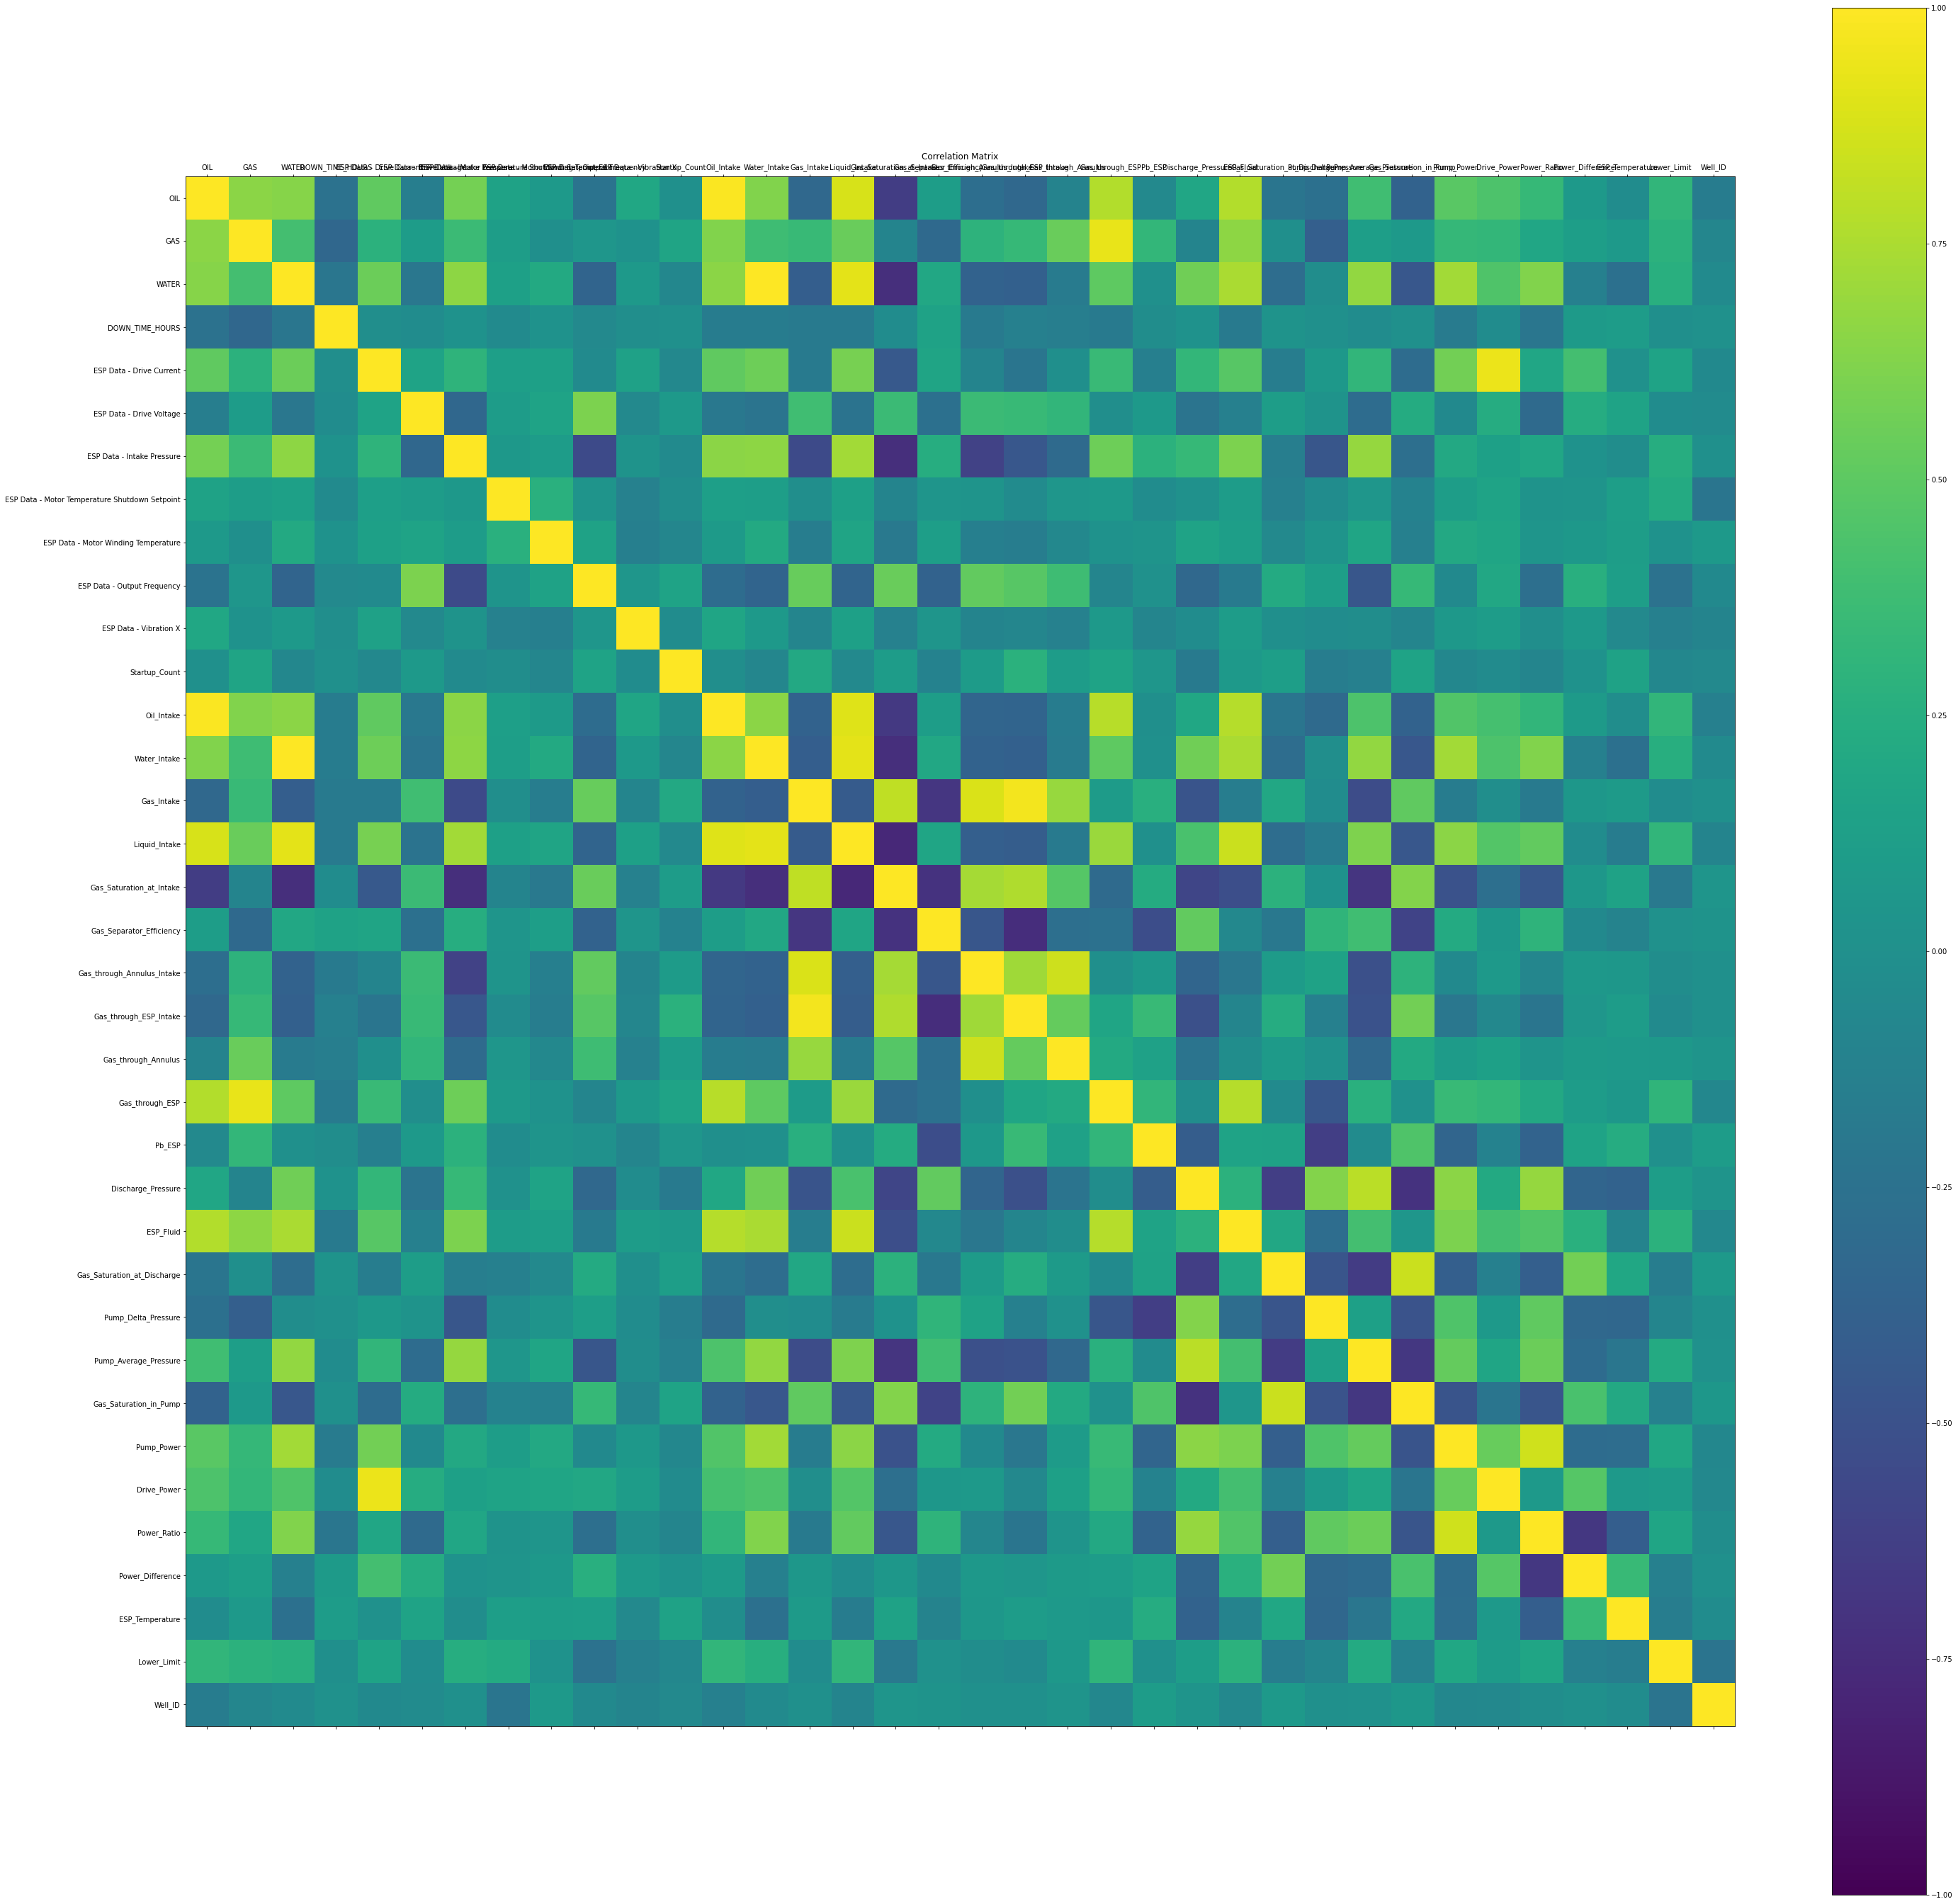

In [43]:
plot_corr(my_data,size = 49)

In [71]:
#lifespan=[]
#for i in len(d):
#    lifespan.append(d[i]["Well_ID"],len(d["Well_ID"]))
    

TypeError: 'int' object is not iterable

In [82]:
#lifespan=list(d.items())
#lifespan2=[]
#for i in len(lifespan):
#    lifespan.append(lifespan[i],len(d["Well_ID"]))
    


TypeError: 'int' object is not iterable

In [83]:
lifespan=list(d.items())
lifespanarray=np.array(lifespan)

C:\Users\Richard\AppData\Local\Temp\ipykernel_29344\215541072.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lifespanarray=np.array(lifespan)


In [89]:
lifespanarray[0,0]

'wellno0'

In [92]:
solutions_df=pd.read_csv('solution.csv')

In [98]:
sorted_sol=solutions_df.sort_values("Well_ID")

sorted_sol.head()

sorted_static=static_df.sort_values("Well_ID")

sorted_static.head()

,Unnamed: 0,Well_ID,AL_Key,Artificial_Lift_Type,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Frequency_Rating,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth,Failure_Type,Failure_Type_Detail
17,17,0,ESP_1,ESP,7649.74,445,12.759959,NaN,NaN,NaN,NaN,NaN,ELECTRICAL,CABLE
128,128,1,ESP_2,ESP,8593.57,415,17.861990,NaN,73.0,1835.0,208.0,0.392309,ELECTRICAL,MOTOR
73,73,4,ESP_2,ESP,7418.04,351,19.130100,NaN,67.1,2626.0,270.0,NaN,ELECTRICAL,MOTOR LEAD EXTENSION (MLE)
100,100,5,ESP_1,ESP,7925.35,445,10.368719,60.0,75.0,1393.0,161.0,NaN,ELECTRICAL,UNKNOWN
109,109,6,ESP_1,ESP,8528.73,415,18.051378,NaN,NaN,NaN,NaN,11.671727,PUMP,SHAFT
